<a href="https://colab.research.google.com/github/kashish049/SMS-SPAM-CLASSIFIER/blob/main/sms_spam_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Import Required Libraries

In [31]:
import numpy as np
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

In [32]:
# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# 2. Load and Explore the Dataset
The UCI SMS Spam Collection dataset is used. You can download it from kaggle.

In [33]:
from google.colab import files

# Upload the file
uploaded = files.upload()

Saving spam.csv to spam (1).csv


In [35]:
# Step 1: Load the dataset
df = pd.read_csv('spam.csv', encoding='ISO-8859-1')
df = df[['v1', 'v2']]
df.columns = ['label', 'message']
#df['label'] = df['label'].map({'ham': 0, 'spam': 1})
# df = df.sample(frac=0.2, random_state=42)  # Use 20% of the data for now


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB
None
  label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...


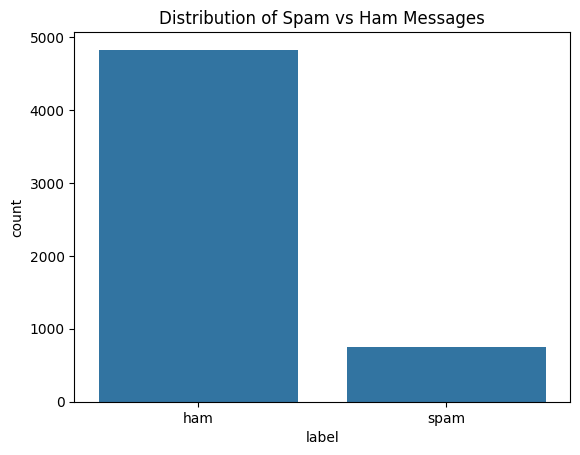

In [36]:
# Check basic info and data distribution
print(df.info())
print(df.head())

# Plot the label distribution
sns.countplot(x='label', data=df)
plt.title('Distribution of Spam vs Ham Messages')
plt.show()

# 3. Data Cleaning and Preprocessing


*   Removing special characters and digits.
*   Tokenizing the message and removing stopwords.
*   Lemmatizing the text for normalization.









In [37]:
def clean_message(message):
    """Cleans and preprocesses the SMS message."""
    message = re.sub(r'\W', ' ', message)  # Remove non-word characters
    message = re.sub(r'\d', ' ', message)  # Remove digits
    message = message.lower()  # Convert to lowercase

    # Tokenize and remove stopwords
    tokens = message.split()
    tokens = [word for word in tokens if word not in stopwords.words('english')]

    # Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(tokens)

# Apply cleaning to the entire dataset
df['cleaned_message'] = df['message'].apply(clean_message)


# 4. Feature Engineering using Skip-Gram Embeddings
We generate 1-grams and 2-grams (skip-gram embeddings) to capture informative word patterns.

In [38]:
# Create the vectorizer with skip-gram embeddings (1-skip-2-grams)
vectorizer = CountVectorizer(ngram_range=(1, 2))  # 1-grams and 2-grams
X = vectorizer.fit_transform(df['cleaned_message'])  # Transform messages into feature vectors
y = df['label'].map({'ham': 0, 'spam': 1})  # Encode labels as 0 (ham) and 1 (spam)

print(f'Feature Matrix Shape: {X.shape}')
df = df[df['label'].isin(['ham', 'spam'])]


Feature Matrix Shape: (5572, 37187)


# 5. Train-Test Split

In [39]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# 6. Model Building: SVM, KNN, and MLP
We train three models:

* SVM (Linear Support Vector Machine)
* KNN (K-Nearest Neighbors)
* MLP (Multilayer Perceptron)

In [40]:
# Train Linear SVM
svm_model = LinearSVC()
svm_model.fit(X_train, y_train)

# Train K-Nearest Neighbors (KNN)
knn_model = KNeighborsClassifier(n_neighbors=5, weights='distance')
knn_model.fit(X_train, y_train)

# Train Multilayer Perceptron (MLP)
mlp_model = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=300, random_state=42)
mlp_model.fit(X_train, y_train)


MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=300, random_state=42)

# 7. Weighted Voting-Based Prediction System
* We assign weights to each model based on prior performance.
* These weights influence the final consensus prediction.

In [41]:
# Define model weights (higher weights for more reliable models)
weights = {
    "SVM": 0.9,  # Highest weight for best performance
    "KNN": 0.8,
    "MLP": 0.85
}

# Dictionary of models
models = {
    "SVM": svm_model,
    "KNN": knn_model,
    "MLP": mlp_model
}

def predict_with_weighted_voting(models, message, weights):
    """Predicts whether a message is spam or ham using weighted voting."""
    cleaned = clean_message(message)  # Clean the input message
    features = vectorizer.transform([cleaned])  # Vectorize the message

    # Collect predictions and apply weights
    weighted_votes = defaultdict(float)
    predictions = {}

    for name, model in models.items():
        pred = model.predict(features)[0]  # Get prediction (0 or 1)
        result = "Spam" if pred == 1 else "Ham"
        predictions[name] = result

        # Add weighted vote
        weighted_votes[result] += weights[name]

    # Display individual predictions
    print("Individual Model Predictions:", predictions)

    # Determine the final prediction based on weighted votes
    final_prediction = max(weighted_votes, key=weighted_votes.get)
    return final_prediction

# Example usage
message = "Congratulations! You've won a free ticket to Bahamas. Call now!"
final_prediction = predict_with_weighted_voting(models, message, weights)
print(f"\nFinal Consensus Prediction: {final_prediction}")


Individual Model Predictions: {'SVM': 'Ham', 'KNN': 'Ham', 'MLP': 'Ham'}

Final Consensus Prediction: Ham


# 8. Evaluate Model Performance

In [42]:
# Function to evaluate and display model performance
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
    print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}")
    print(f"Classification Report:\n{classification_report(y_test, y_pred)}")

# Evaluate all models
print("SVM Performance:")
evaluate_model(svm_model, X_test, y_test)

print("\nKNN Performance:")
evaluate_model(knn_model, X_test, y_test)

print("\nMLP Performance:")
evaluate_model(mlp_model, X_test, y_test)


SVM Performance:
Accuracy: 0.986
Confusion Matrix:
[[1447    1]
 [  23  201]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1448
           1       1.00      0.90      0.94       224

    accuracy                           0.99      1672
   macro avg       0.99      0.95      0.97      1672
weighted avg       0.99      0.99      0.99      1672


KNN Performance:
Accuracy: 0.929
Confusion Matrix:
[[1448    0]
 [ 118  106]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      1448
           1       1.00      0.47      0.64       224

    accuracy                           0.93      1672
   macro avg       0.96      0.74      0.80      1672
weighted avg       0.93      0.93      0.92      1672


MLP Performance:
Accuracy: 0.983
Confusion Matrix:
[[1448    0]
 [  28  196]]
Classification Report:
              precision    recall  f1-sco

# 9.Confusion Matrix Visualization

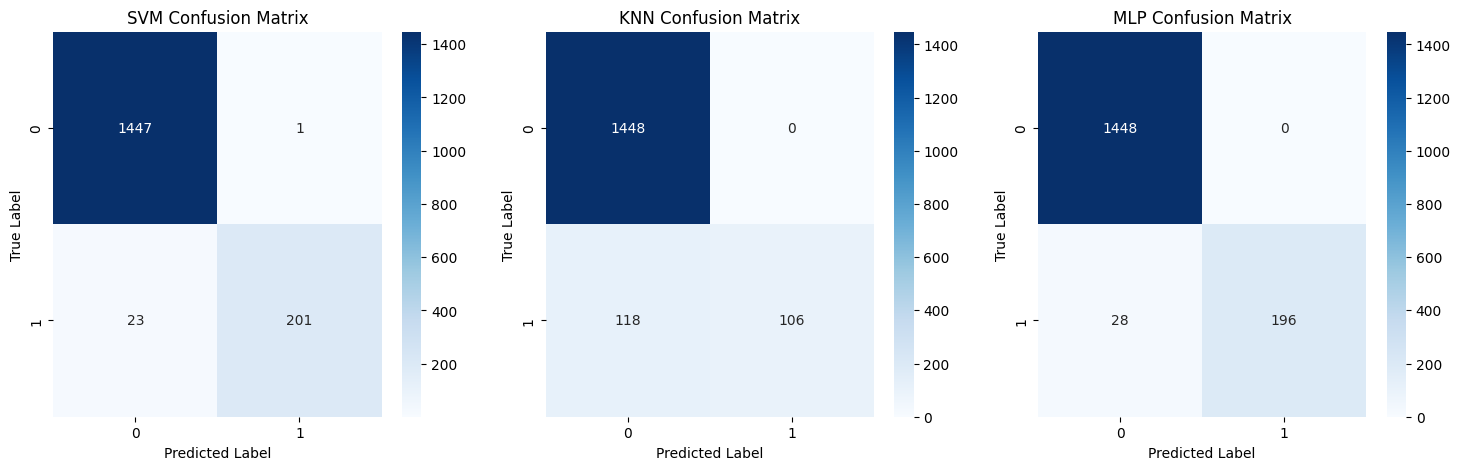

In [43]:
# Plot confusion matrices for all models
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, model, title in zip(axes, [svm_model, knn_model, mlp_model], ['SVM', 'KNN', 'MLP']):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'{title} Confusion Matrix')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

plt.show()


# Prediction Example: Spam Message

In [44]:
# Predict using the weighted voting system
spam_message = "You have won a $1000 Walmart gift card! Click here to claim your prize now."
spam_prediction = predict_with_weighted_voting(models, spam_message, weights)
print(f"Prediction for Spam Message: {spam_prediction}")


Individual Model Predictions: {'SVM': 'Spam', 'KNN': 'Ham', 'MLP': 'Spam'}
Prediction for Spam Message: Spam


In [45]:
# Predict using the weighted voting system
ham_message = "Don't forget to submit the project report by tomorrow morning."
ham_prediction = predict_with_weighted_voting(models, ham_message, weights)
print(f"Prediction for Ham Message: {ham_prediction}")


Individual Model Predictions: {'SVM': 'Ham', 'KNN': 'Ham', 'MLP': 'Ham'}
Prediction for Ham Message: Ham


In [46]:
# Colab cell (code)
!pip install -q joblib flask flask-cors pyngrok scikit-learn nltk


In [47]:
# Colab cell (code)
from google.colab import drive
drive.mount('/content/drive')

# create a folder for the model files (optional)
!mkdir -p /content/drive/MyDrive/sms_spam_model


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [48]:
# Colab cell (code)
import joblib
import os

# path where files will be saved (adjust if using Drive)
out_dir = "/content/sms_spam_model"
os.makedirs(out_dir, exist_ok=True)

# If you have a full pipeline (recommended) save that.
# If not, save vectorizer and model separately.
# Example: vectorizer and model exist in the notebook scope:

joblib.dump(vectorizer, os.path.join(out_dir, "vectorizer.pkl"))
joblib.dump(model, os.path.join(out_dir, "spam_classifier.pkl"))

print("Saved vectorizer and model to:", out_dir)


Saved vectorizer and model to: /content/sms_spam_model


In [49]:
# Colab cell (code) - write app.py
app_code = r"""
from flask import Flask, request, jsonify, send_from_directory
from flask_cors import CORS
import joblib
import os
import re

app = Flask(__name__, static_folder="static")
CORS(app)

MODEL_DIR = os.environ.get("MODEL_DIR", "/content/sms_spam_model")

# Load vectorizer and model
vectorizer_path = os.path.join(MODEL_DIR, "vectorizer.pkl")
model_path = os.path.join(MODEL_DIR, "spam_classifier.pkl")

if not os.path.exists(vectorizer_path) or not os.path.exists(model_path):
    raise FileNotFoundError("vectorizer.pkl or spam_classifier.pkl not found in " + MODEL_DIR)

vectorizer = joblib.load(vectorizer_path)
model = joblib.load(model_path)

def simple_preprocess(text):
    # Minimal preprocessing — adapt to match what you did in training.
    text = text.lower()
    text = re.sub(r'http\S+', ' ', text)           # remove URLs
    text = re.sub(r'[^a-z0-9\s]', ' ', text)      # remove special characters
    text = re.sub(r'\s+', ' ', text).strip()
    return text

@app.route("/")
def index():
    # serve frontend index if placed in /static
    return send_from_directory("static", "index.html")

@app.route("/predict", methods=["POST"])
def predict():
    data = request.get_json(force=True)
    message = data.get("message", "")
    if not isinstance(message, str):
        return jsonify({"error": "message must be a string"}), 400

    # Preprocess -> vectorize -> predict
    text = simple_preprocess(message)
    X = vectorizer.transform([text])
    pred = model.predict(X)[0]

    # Map labels to human readable form (change if your model uses other encoding)
    result = "spam" if int(pred) == 1 else "ham"
    return jsonify({"prediction": result})

if __name__ == "__main__":
    # For local Colab testing
    app.run(host="0.0.0.0", port=5000)
"""

with open("app.py", "w") as f:
    f.write(app_code)

print("Wrote app.py")


Wrote app.py


In [50]:
# Colab cell (code) - create frontend file
html = r"""
<!doctype html>
<html>
<head>
  <meta charset="utf-8"/>
  <meta name="viewport" content="width=device-width, initial-scale=1"/>
  <title>SMS Spam Classifier</title>
  <style>
    body { font-family: Arial, sans-serif; display:flex; align-items:center; justify-content:center; height:100vh; background:#f7f8fc; }
    .card { background:white; padding:24px; border-radius:12px; box-shadow: 0 6px 18px rgba(0,0,0,0.06); width:360px; }
    textarea { width:100%; height:120px; padding:12px; border-radius:8px; border:1px solid #ddd; resize:none; font-size:15px; }
    button { margin-top:12px; width:100%; padding:10px; border-radius:8px; border:none; background:#4f46e5; color:white; font-weight:600; cursor:pointer; }
    .result { margin-top:14px; font-weight:700; text-align:center; }
  </style>
</head>
<body>
  <div class="card">
    <h2>📩 SMS Spam Classifier</h2>
    <textarea id="message" placeholder="Type an SMS message here..."></textarea>
    <button onclick="predict()">Check</button>
    <div id="result" class="result"></div>
  </div>

  <script>
    async function predict() {
      const message = document.getElementById("message").value;
      document.getElementById("result").innerText = "Checking...";
      try {
        const resp = await fetch("/predict", {
          method: "POST",
          headers: {"Content-Type": "application/json"},
          body: JSON.stringify({ message })
        });
        const data = await resp.json();
        if (data.prediction) {
          document.getElementById("result").innerText = "Prediction: " + data.prediction.toUpperCase();
        } else if (data.error) {
          document.getElementById("result").innerText = "Error: " + data.error;
        } else {
          document.getElementById("result").innerText = JSON.stringify(data);
        }
      } catch (err) {
        document.getElementById("result").innerText = "Request failed: " + err;
      }
    }
  </script>
</body>
</html>
"""

import os
os.makedirs("static", exist_ok=True)
with open("static/index.html", "w") as f:
    f.write(html)

print("Wrote static/index.html")


Wrote static/index.html


In [51]:
# Colab cell (run once) - paste your ngrok authtoken when prompted
from pyngrok import ngrok
# Paste your token string
ngrok_token = input("Paste your ngrok authtoken (or press Enter to skip): ").strip()
if ngrok_token:
    ngrok.set_auth_token(ngrok_token)
    print("Ngrok token set.")
else:
    print("No token set. You can run without token but token is recommended.")


Paste your ngrok authtoken (or press Enter to skip): 34xg6ulfx79BXhXX7CXNKQgznca_3ArKnBhAU5RQ1RZMNf9hH
Ngrok token set.


In [52]:
# Colab cell (run) - start ngrok tunnel and launch the app in the background
from pyngrok import ngrok
import subprocess, time

# Open tunnel on port 5000
public_url = ngrok.connect(5000).public_url
print(" * ngrok tunnel:", public_url)

# Start Flask app in background (nohup keeps it running)
# If you want logs, remove > /dev/null
cmd = "nohup python3 app.py > flask_log.txt 2>&1 &"
print("Starting Flask with command:", cmd)
subprocess.call(cmd, shell=True)

time.sleep(2)
print("Flask should be running. Visit the URL above in your browser.")


 * ngrok tunnel: https://evaluative-jaquelyn-aspersively.ngrok-free.dev
Starting Flask with command: nohup python3 app.py > flask_log.txt 2>&1 &
Flask should be running. Visit the URL above in your browser.


In [53]:
# Colab cell (code) - test with requests
import requests
test_msg = "Congratulations, you've won a free phone. Reply to claim!"
resp = requests.post(public_url + "/predict", json={"message": test_msg})
print("Status:", resp.status_code)
print("Response:", resp.json())


Status: 200
Response: {'prediction': 'spam'}


In [54]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline([
   ('preproc', YourPreprocessor()),   # custom transformer
   ('vectorizer', vectorizer),
   ('clf', model)
])
joblib.dump(pipeline, 'pipeline.pkl')


NameError: name 'YourPreprocessor' is not defined